In [1]:
import ee
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Getting Credentials and initializing Project

In [2]:
from google.colab import userdata
key_data = userdata.get('SERVICE_ACCOUNT_CREDENTIALS')

credentials = ee.ServiceAccountCredentials(email = 'datascience@datascience-474615.iam.gserviceaccount.com',key_data=key_data)

ee.Initialize(credentials,
              project='datascience-474615',
              opt_url='https://earthengine-highvolume.googleapis.com'
)


In [3]:
amazon_shape = ee.FeatureCollection('projects/datascience-474615/assets/amazonia_polygons')

In [4]:
canopy_dataset = ee.ImageCollection("MODIS/061/MOD44B").select("Percent_Tree_Cover")

canopy_nominal_scale = canopy_dataset.first().projection().nominalScale().getInfo()

canopy_threshold = 50

Wir nutzen eine Baumkronenabdeckungs von 50% als unseren Schwellwert, den wir nutzen um eine gegebene Fläche als Regenwald zu klassifizieren. Dies basiert einer klassifizierung, die sich in der Literatur wiederfindet, wonach eine Abdeckung von 41% bis 70% als einen mittel dichten Wald klassifiziert wird.

https://www.sciencedirect.com/science/article/pii/S1470160X24011671

In [5]:
import geemap

# Create a map object.
m = geemap.Map()
m.centerObject(amazon_shape,zoom = 4)

# Add the elevation model to the map object.
m.add_ee_layer(canopy_dataset.first().clip(amazon_shape).gte(canopy_threshold),{'palette': ['222222', '3faa00']},"2000")
m.add_ee_layer(canopy_dataset.sort('system:time_start', False).first().clip(amazon_shape).gte(canopy_threshold),{'palette': ['222222', '3faa00']},"Today")

# Display the map.
display(m)

Map(center=[-5.52182165075565, -61.917628710127865], controls=(WidgetControl(options=['position', 'transparent…

In [6]:
import datetime

def sum_img(img: ee.Image):
  sum = img.gte(canopy_threshold).reduceRegion(
      reducer = ee.Reducer.sum(),
      geometry = amazon_shape.bounds(),
      scale = canopy_nominal_scale,
      maxPixels = 1e9
  ).get('Percent_Tree_Cover')

  return ee.Feature(None,{
      'canopy' : ee.Number(sum).divide(10000/(canopy_nominal_scale*canopy_nominal_scale)).divide(1000000),
      'date' : img.get('system:time_start')
  })

canopy_feature_collection = canopy_dataset.map(sum_img)

canopy_cover_y = canopy_feature_collection.aggregate_array('canopy').getInfo()
canopy_cover_x = [datetime.date.fromtimestamp(int(x)/1000) for x in canopy_feature_collection.aggregate_array('date').getInfo()]

print(canopy_cover_y)
print(canopy_cover_x)



[600.6144459683385, 589.1294785806355, 604.0008765756514, 590.0485581467914, 604.3322749061589, 584.3038958989006, 587.4184283821534, 570.076619975852, 582.7048361607525, 579.6608807134337, 583.4273074068199, 582.8379581680551, 581.235759930699, 571.2606401575667, 553.246934572661, 553.6429867486875, 559.7066523881206, 576.6180720695545, 562.7959511550685, 564.5694729411157, 566.0169623373641, 550.3979052369612, 559.1642709931973, 559.7421835335234, 566.6228258992144]
[datetime.date(2000, 3, 5), datetime.date(2001, 3, 6), datetime.date(2002, 3, 6), datetime.date(2003, 3, 6), datetime.date(2004, 3, 5), datetime.date(2005, 3, 6), datetime.date(2006, 3, 6), datetime.date(2007, 3, 6), datetime.date(2008, 3, 5), datetime.date(2009, 3, 6), datetime.date(2010, 3, 6), datetime.date(2011, 3, 6), datetime.date(2012, 3, 5), datetime.date(2013, 3, 6), datetime.date(2014, 3, 6), datetime.date(2015, 3, 6), datetime.date(2016, 3, 5), datetime.date(2017, 3, 6), datetime.date(2018, 3, 6), datetime.date

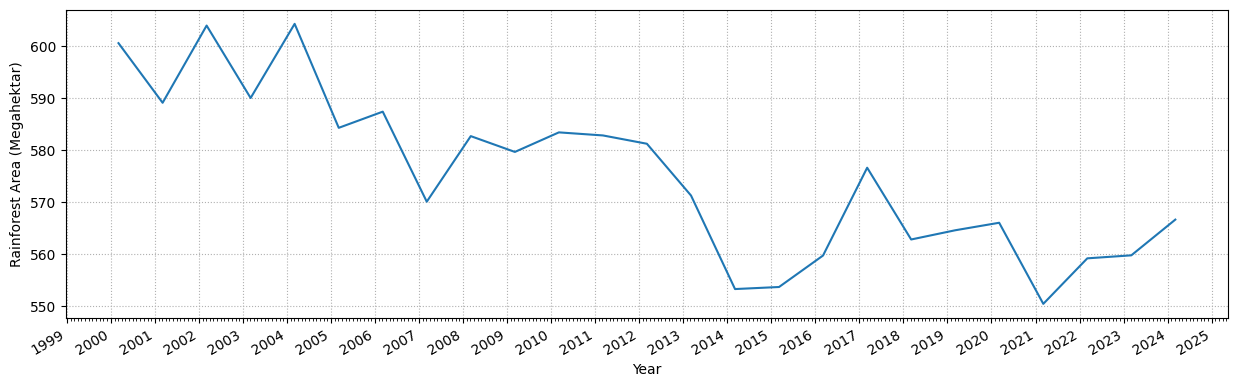

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15,4))

ax.grid(linestyle = 'dotted')
ax.plot(canopy_cover_x,canopy_cover_y)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_label_text('Year')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax.yaxis.set_units("Mha")
ax.yaxis.set_label_text('Rainforest Area (Megahektar)')

plt.show()

In [8]:
import pandas as pd
import datetime

# needed for constant spacing between datestamps to allow for forecasts
canopy_cover_x_regular = [datetime.date(e.year, e.month, 1) for e in canopy_cover_x]

ts = pd.Series(canopy_cover_y, pd.DatetimeIndex(canopy_cover_x_regular,freq = pd.infer_freq(canopy_cover_x_regular)))

print(ts)

2000-03-01    600.614446
2001-03-01    589.129479
2002-03-01    604.000877
2003-03-01    590.048558
2004-03-01    604.332275
2005-03-01    584.303896
2006-03-01    587.418428
2007-03-01    570.076620
2008-03-01    582.704836
2009-03-01    579.660881
2010-03-01    583.427307
2011-03-01    582.837958
2012-03-01    581.235760
2013-03-01    571.260640
2014-03-01    553.246935
2015-03-01    553.642987
2016-03-01    559.706652
2017-03-01    576.618072
2018-03-01    562.795951
2019-03-01    564.569473
2020-03-01    566.016962
2021-03-01    550.397905
2022-03-01    559.164271
2023-03-01    559.742184
2024-03-01    566.622826
Freq: YS-MAR, dtype: float64


In [9]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -2.1841233927505077
p-value: 0.21205812710311273


Der P-Wert ist über dem Signifikanzniveau von 0.05 und damit hat die Kurve einen Trend. Darunter können Sie außerdem die Kurve noch einmal sehen, nachdem eine einfache Differenzierung angewendet wurde.

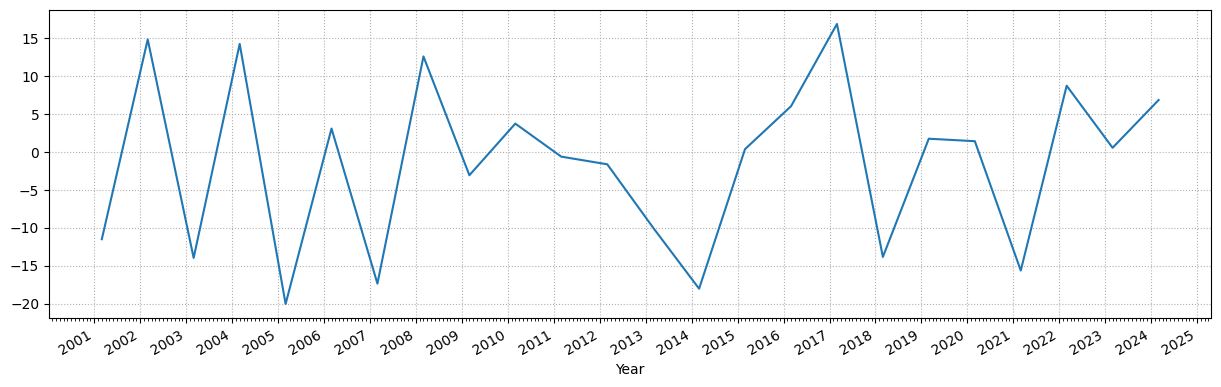

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15,4))

ax.grid(linestyle = 'dotted')
ax.plot(ts.diff().dropna()) # Differencing Done here

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_label_text('Year')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

plt.show()

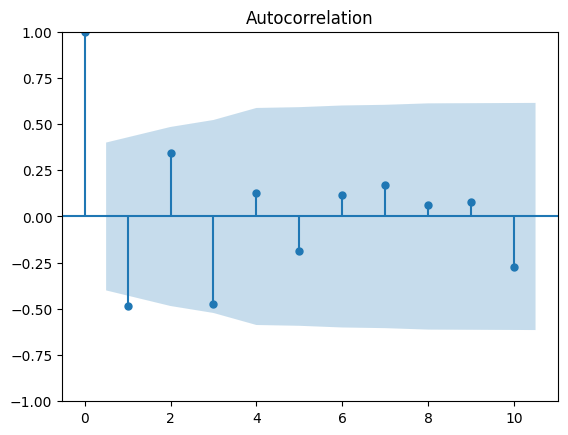

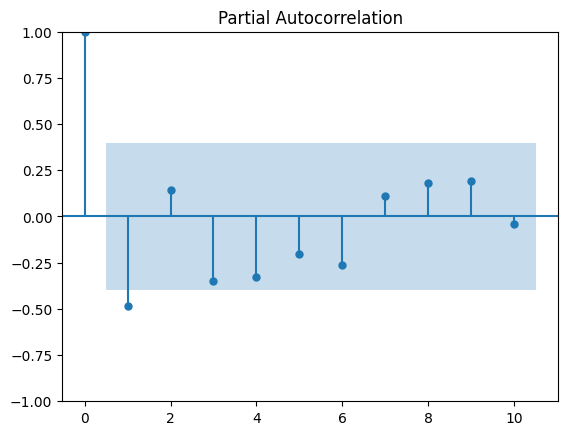

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts.diff().dropna(), lags=10)
plot_pacf(ts.diff().dropna(), lags=10)
plt.show()

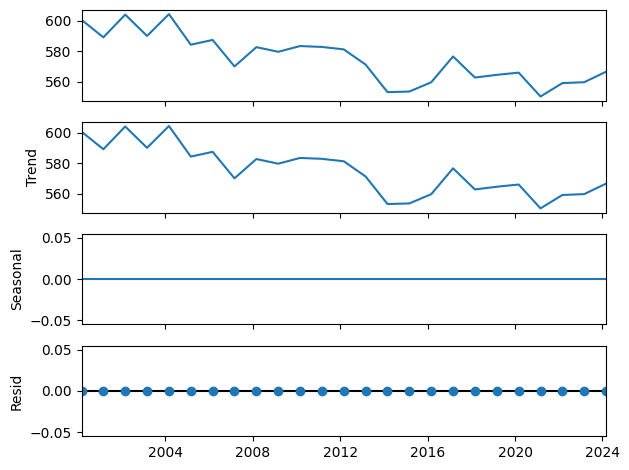

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(
    ts, model='additive', extrapolate_trend='freq')

result.plot()
plt.tight_layout()
plt.show()

Dies zeigt, das wir keine (signifikante) Saisonaliät in unserer Zeitreihe haben und diesen Teil des SARIMA modells ignorieren können.

In [13]:
!pip3 install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 16.6 MB/s eta 0:00:00


In [14]:
from pmdarima import auto_arima
auto_arima_model = auto_arima(ts,
                           start_p=0, start_q=0,
                           max_p=6, max_q=6,
                           d=1, max_d=2,trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=False)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=187.280, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=2.79 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=inf, Time=1.97 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=182.734, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=182.843, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=1.61 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=184.053, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=184.832, Time=0.42 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : AIC=181.635, Time=0.36 sec


In [15]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   25
Model:               SARIMAX(3, 1, 2)   Log Likelihood                 -82.614
Date:                Thu, 20 Nov 2025   AIC                            179.227
Time:                        18:45:32   BIC                            187.474
Sample:                    03-01-2000   HQIC                           181.415
                         - 03-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0272      1.123     -1.805      0.071      -4.229       0.174
ar.L1          0.5534      0.288      1.924      0.054      -0.010       1.117
ar.L2         -0.0509      0.297     -0.172      0.864      -0.633       0.531
ar.L3         -0.7296      0.241     -3.024      0.002      -1.202      -0.257
ma.L1         -1.3326      1.059     -1.258      0.208      -3.408       0.743
ma.L2          0.9496      1.221      0.778      0.437      -1.443       3.343
sigma2        45.6943     55.906      0.817      0.414     -63.878     155.267
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.12
Prob(Q):                              0.91   Prob(JB):                         0.94
Heteroskedasticity (H):               1.92   Skew:                             0.14
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

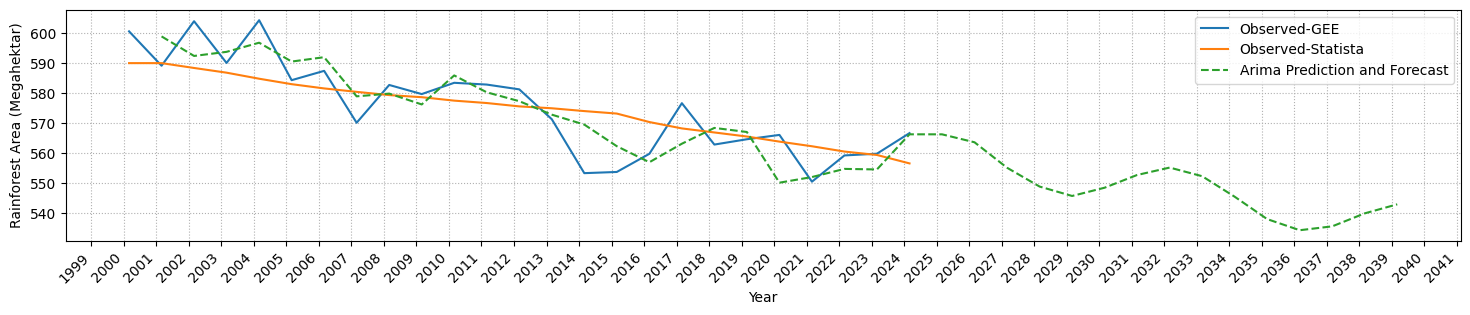

In [18]:
from statsmodels.tsa.arima.model import ARIMA

differencing = int(auto_arima_model.order[1])

# exclude d first elements, due to the differencing producing sudden jumps in the model
in_sample_prediction = auto_arima_model.predict_in_sample()[differencing:]
out_of_sample_prediction = auto_arima_model.predict(n_periods=15)

fig, ax = plt.subplots(1, 1, figsize=(18,3))
ax.grid(linestyle = 'dotted')

ax.plot(ts, label='Observed-GEE')

# Statista rainforest loss: https://de.statista.com/statistik/daten/studie/1269192/umfrage/verlust-an-regenwald-brasilien/
loss = [1.62, 1.57, 2.02, 1.82, 1.42, 1.15, 1.08, 0.7, 1.15, 0.8, 1.12, 0.63, 0.94, 0.83, 2.83, 2.13, 1.35, 1.36, 1.7, 1.55, 1.77, 1.14, 2.82]

# numbers right here vary a lot, especially for the whole amazone basin, they range between 500 and 600 megahektar
area_2000 = 590

actual_area = [area_2000-sum(loss[:i+1]) for i in range(len(loss))]

ax.plot(pd.Series([area_2000,area_2000] + actual_area,index = ts.index), label = 'Observed-Statista')

ax.plot(pd.concat([in_sample_prediction,out_of_sample_prediction]), label='Arima Prediction and Forecast', linestyle='--')

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_label_text('Year')

for label in ax.get_xticklabels(which='major'):
    label.set(rotation=45, horizontalalignment='right')

ax.yaxis.set_units("Mha")
ax.yaxis.set_label_text('Rainforest Area (Megahektar)')

ax.legend()
fig.show()

Hier ist noch eine Visuelle Darstellung der verlorenen/gewonnen Regenwaldfläche




In [17]:
import geemap

m = geemap.Map()
m.centerObject(amazon_shape,zoom = 4)

m.add_ee_layer(canopy_dataset.first().gte(canopy_threshold).subtract(canopy_dataset.sort('system:time_start', False).first().gte(canopy_threshold)).clip(amazon_shape),{'min': -1, 'max':1, 'palette' : ['0f0','555','f00']},"Loss/Gain since 2000")

display(m)

Map(center=[-5.52182165075565, -61.917628710127865], controls=(WidgetControl(options=['position', 'transparent…